<a href="https://colab.research.google.com/github/Vidit0018/Ontocom/blob/main/ontology_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch pandas scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 855.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("/content/synthetic_ontology_dataset.csv")
print(f"Original dataframe shape: {df.shape}")

feature_cols = df.columns[:-2]
target_cols = ["PME", "PME_Calculated"]

X = df[feature_cols].values
y = df[target_cols].values
print(f"X shape: {X.shape}, y shape: {y.shape}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_cnn = X_scaled.reshape(-1, 1, 4, 4)
print(f"X_cnn shape: {X_cnn.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, random_state=42)

class OntologyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = OntologyDataset(X_train, y_train)
test_dataset = OntologyDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

class CostEstimatorCNN(nn.Module):
    def __init__(self):
        super(CostEstimatorCNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=2, padding=0),
            nn.ReLU(),
        )


        self.flat_dim = 32 * 2 * 2

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flat_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CostEstimatorCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")


model.eval()
with torch.no_grad():
    total_loss = 0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        total_loss += loss.item()
    print(f"\nTest Loss: {total_loss/len(test_loader):.4f}")



Original dataframe shape: (1480, 18)
X shape: (1480, 16), y shape: (1480, 2)
X_cnn shape: (1480, 1, 4, 4)
Epoch 1/30, Loss: 385.2811
Epoch 2/30, Loss: 334.4997
Epoch 3/30, Loss: 319.6324
Epoch 4/30, Loss: 305.1181
Epoch 5/30, Loss: 287.8666
Epoch 6/30, Loss: 278.8874
Epoch 7/30, Loss: 266.3975
Epoch 8/30, Loss: 255.7276
Epoch 9/30, Loss: 244.1289
Epoch 10/30, Loss: 233.3740
Epoch 11/30, Loss: 222.0121
Epoch 12/30, Loss: 215.4451
Epoch 13/30, Loss: 198.0063
Epoch 14/30, Loss: 185.5243
Epoch 15/30, Loss: 174.4531
Epoch 16/30, Loss: 159.8336
Epoch 17/30, Loss: 144.2348
Epoch 18/30, Loss: 126.3279
Epoch 19/30, Loss: 110.9446
Epoch 20/30, Loss: 95.1675
Epoch 21/30, Loss: 82.5632
Epoch 22/30, Loss: 69.3371
Epoch 23/30, Loss: 61.4167
Epoch 24/30, Loss: 52.2542
Epoch 25/30, Loss: 42.1609
Epoch 26/30, Loss: 35.8795
Epoch 27/30, Loss: 31.1319
Epoch 28/30, Loss: 26.4888
Epoch 29/30, Loss: 22.6423
Epoch 30/30, Loss: 19.3231

Test Loss: 16.9359


In [ ]:

model.eval()
with torch.no_grad():
    all_targets = []
    all_predictions = []

    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)


        all_targets.append(y_batch.cpu().numpy())
        all_predictions.append(outputs.cpu().numpy())


    y_true = np.vstack(all_targets)
    y_pred = np.vstack(all_predictions)


    mse = np.mean((y_true - y_pred) ** 2, axis=0)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred), axis=0)


    y_mean = np.mean(y_true, axis=0)
    ss_total = np.sum((y_true - y_mean) ** 2, axis=0)
    ss_residual = np.sum((y_true - y_pred) ** 2, axis=0)
    r_squared = 1 - (ss_residual / ss_total)

    print(f"\nTest MSE: {mse}")
    print(f"Test RMSE: {rmse}")
    print(f"Test MAE: {mae}")
    print(f"R-squared: {r_squared}")


    for i, col in enumerate(target_cols):
        print(f"\nPerformance for {col}:")
        print(f"  RMSE: {rmse[i]:.4f}")
        print(f"  MAE: {mae[i]:.4f}")
        print(f"  R²: {r_squared[i]:.4f}")




Test MSE: [35.357555    0.34083313]
Test RMSE: [5.946222   0.58380914]
Test MAE: [3.3783514  0.44626936]
R-squared: [0.93368006 0.7368296 ]

Performance for PME:
  RMSE: 5.9462
  MAE: 3.3784
  R²: 0.9337

Performance for PME_Calculated:
  RMSE: 0.5838
  MAE: 0.4463
  R²: 0.7368


In [ ]:
torch.save(model.state_dict(), "pme_model.pt")



🔍 Error Metrics:
RMSE: PME = 5.8340, PME_Calculated = 0.5898
MAE : PME = 3.4140, PME_Calculated = 0.4562
R²  : PME = 0.9475, PME_Calculated = 0.8528


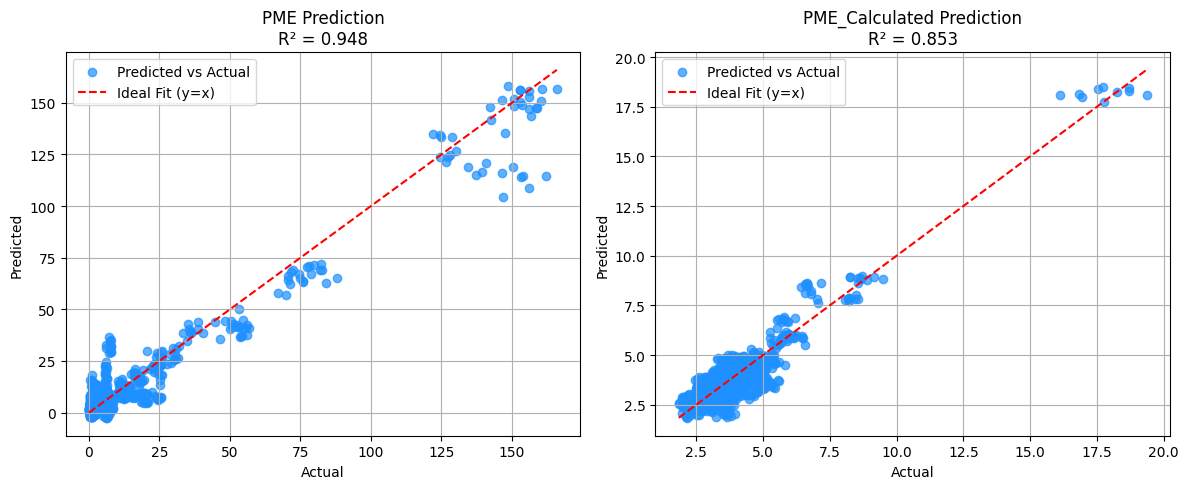

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


class CostEstimatorCNN(nn.Module):
    def __init__(self):
        super(CostEstimatorCNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=2),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 2 * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.fc(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CostEstimatorCNN().to(device)
model.load_state_dict(torch.load("pme_model.pt", map_location=device))
model.eval()


data = pd.read_csv("synthetic_ontology_dataset.csv")
X = data.drop(columns=["PME", "PME_Calculated"]).values
y_actual = data[["PME", "PME_Calculated"]].values


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_cnn = X_scaled.reshape(-1, 1, 4, 4)


X_tensor = torch.tensor(X_cnn, dtype=torch.float32).to(device)


with torch.no_grad():
    y_pred = model(X_tensor).cpu().numpy()


rmse = np.sqrt(mean_squared_error(y_actual, y_pred, multioutput='raw_values'))
mae = mean_absolute_error(y_actual, y_pred, multioutput='raw_values')
r2 = r2_score(y_actual, y_pred, multioutput='raw_values')

print(f"\n🔍 Error Metrics:")
print(f"RMSE: PME = {rmse[0]:.4f}, PME_Calculated = {rmse[1]:.4f}")
print(f"MAE : PME = {mae[0]:.4f}, PME_Calculated = {mae[1]:.4f}")
print(f"R²  : PME = {r2[0]:.4f}, PME_Calculated = {r2[1]:.4f}")


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

titles = ['PME', 'PME_Calculated']
for i in range(2):
    axs[i].scatter(y_actual[:, i], y_pred[:, i], alpha=0.7, color='dodgerblue', label='Predicted vs Actual')
    axs[i].plot([y_actual[:, i].min(), y_actual[:, i].max()],
                [y_actual[:, i].min(), y_actual[:, i].max()],
                'r--', label='Ideal Fit (y=x)')
    axs[i].set_title(f'{titles[i]} Prediction\nR² = {r2[i]:.3f}')
    axs[i].set_xlabel('Actual')
    axs[i].set_ylabel('Predicted')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()


Dont Change any Code segment above this !!



🧪 Arbitrary Input Test
Input features (mean of dataset):
[1.04176661 1.03508281 0.91831854 1.38334285 0.9463945  0.98839411
 0.87132814 1.10855185 1.10826308 1.02831271 1.02823127 0.98984635
 1.03162599 1.03161339 1.02288095 0.85822241]

Model Prediction:
PME: 2.7927, PME_Calculated: 3.2059


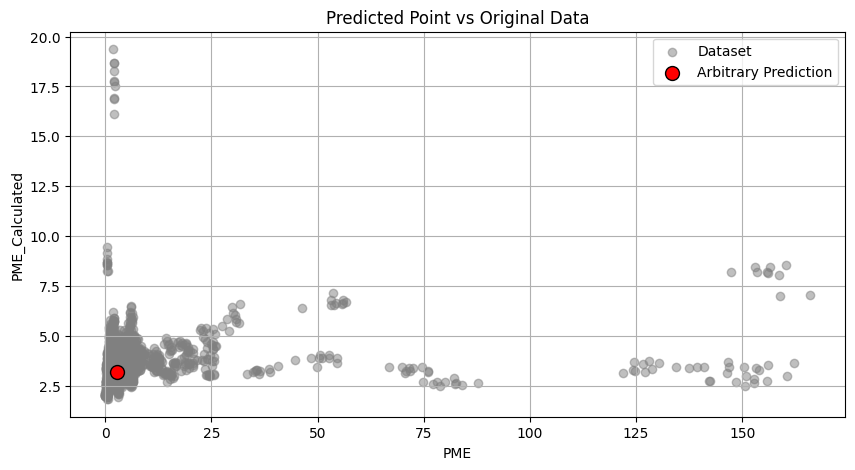

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


class CostEstimatorCNN(nn.Module):
    def __init__(self):
        super(CostEstimatorCNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=2),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 2 * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.fc(x)
        return x


data = pd.read_csv("/content/synthetic_ontology_dataset.csv")


X = data.drop(columns=["PME", "PME_Calculated"]).values
y_actual = data[["PME", "PME_Calculated"]].values


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CostEstimatorCNN().to(device)
model.load_state_dict(torch.load("pme_model.pt", map_location=device))
model.eval()


sample_input = data.drop(columns=["PME", "PME_Calculated"]).mean().values
sample_input_scaled = scaler.transform(sample_input.reshape(1, -1))
sample_input_cnn = sample_input_scaled.reshape(1, 1, 4, 4)
sample_tensor = torch.tensor(sample_input_cnn, dtype=torch.float32).to(device)


with torch.no_grad():
    sample_pred = model(sample_tensor).cpu().numpy()[0]

print("\n🧪 Arbitrary Input Test")
print("Input features (mean of dataset):")
print(sample_input)
print("\nModel Prediction:")
print(f"PME: {sample_pred[0]:.4f}, PME_Calculated: {sample_pred[1]:.4f}")


plt.figure(figsize=(10, 5))
plt.scatter(y_actual[:, 0], y_actual[:, 1], label="Dataset", alpha=0.5, color='gray')
plt.scatter(sample_pred[0], sample_pred[1], color='red', label="Arbitrary Prediction", s=100, edgecolors='black')
plt.xlabel("PME")
plt.ylabel("PME_Calculated")
plt.title("Predicted Point vs Original Data")
plt.grid(True)
plt.legend()
plt.show()



🔢 Arbitrary Input Given to Model (Raw Features):
DCPLX            1.041767
CCPLX            1.035083
ICPLX            0.918319
DATA             1.383343
REUSE            0.946394
DOCU             0.988394
OI               0.871328
OCAP             1.108552
DECAP            1.108263
OEXP             1.028313
DEEXP            1.028231
LEXP             0.989846
TEXP             1.031626
TOOL             1.031613
SCED             1.022881
PM_MULTIPLIER    0.858222
dtype: float64

📐 Scaled & Reshaped Input Sent to CNN:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

🎯 Closest Actual PME Pair in Dataset (for simulated error comparison):
PME: 1.8221, PME_Calculated: 3.5314

📉 Error Metrics vs Closest Ground Truth:
RMSE: 0.7238
MAE : 0.6480
R²  : nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


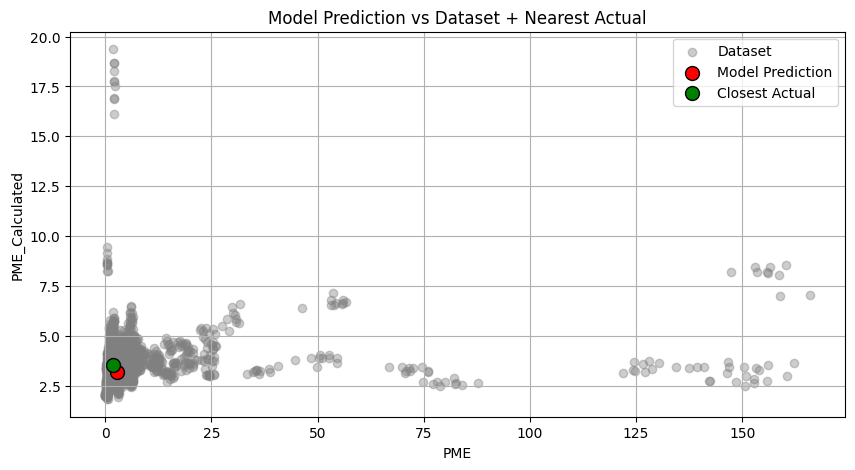

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define model class
class CostEstimatorCNN(nn.Module):
    def __init__(self):
        super(CostEstimatorCNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=2),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 2 * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.fc(x)
        return x


data = pd.read_csv("/content/synthetic_ontology_dataset.csv")
X = data.drop(columns=["PME", "PME_Calculated"]).values
y_actual = data[["PME", "PME_Calculated"]].values


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CostEstimatorCNN().to(device)
model.load_state_dict(torch.load("pme_model.pt", map_location=device))
model.eval()


sample_input = data.drop(columns=["PME", "PME_Calculated"]).mean().values
sample_input_scaled = scaler.transform(sample_input.reshape(1, -1))
sample_input_cnn = sample_input_scaled.reshape(1, 1, 4, 4)
sample_tensor = torch.tensor(sample_input_cnn, dtype=torch.float32).to(device)


with torch.no_grad():
    sample_pred = model(sample_tensor).cpu().numpy()[0]


print("\n🔢 Arbitrary Input Given to Model (Raw Features):")
print(pd.Series(sample_input, index=data.columns[:-2]))

print("\n📐 Scaled & Reshaped Input Sent to CNN:")
print(sample_input_scaled.reshape(4, 4))

from sklearn.metrics.pairwise import euclidean_distances
distances = euclidean_distances(sample_input_scaled, X_scaled)
closest_idx = np.argmin(distances)
closest_actual = y_actual[closest_idx]

print("\n🎯 Closest Actual PME Pair in Dataset (for simulated error comparison):")
print(f"PME: {closest_actual[0]:.4f}, PME_Calculated: {closest_actual[1]:.4f}")


rmse = np.sqrt(mean_squared_error(closest_actual, sample_pred))
mae = mean_absolute_error(closest_actual, sample_pred)
r2 = r2_score(closest_actual.reshape(1, -1), sample_pred.reshape(1, -1))

print("\n📉 Error Metrics vs Closest Ground Truth:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")


plt.figure(figsize=(10, 5))
plt.scatter(y_actual[:, 0], y_actual[:, 1], label="Dataset", alpha=0.4, color='gray')
plt.scatter(sample_pred[0], sample_pred[1], color='red', label="Model Prediction", s=100, edgecolors='black')
plt.scatter(closest_actual[0], closest_actual[1], color='green', label="Closest Actual", s=100, edgecolors='black')
plt.xlabel("PME")
plt.ylabel("PME_Calculated")
plt.title("Model Prediction vs Dataset + Nearest Actual")
plt.grid(True)
plt.legend()
plt.show()
